In [3]:
from nltk.translate.bleu_score import sentence_bleu
from jiwer import wer
from transformers import pipeline
import numpy as np

In [2]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.2 MB/s eta 0:00:00


In [4]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_sentence_from_tokens(tokens):
    input_text = " ".join(tokens)
    inputs = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(inputs, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2, early_stopping=True)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
from nltk.translate.bleu_score import sentence_bleu
from jiwer import wer
def compute_bleu(reference, generated):
    reference = [reference.split()]
    generated = generated.split()
    return sentence_bleu(reference, generated)
def compute_wer(reference, generated):
    return wer(reference, generated)

In [6]:
def process_csv(csv_file):
    with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)

        for row in csv_reader:
            input_tokens = row['input_tokens'].split()
            reference_sentence = row['reference_sentence']
            generated_sentence = generate_sentence_from_tokens(input_tokens)
            print(f"Generated Sentence: {generated_sentence}")
            bleu_score = compute_bleu(reference_sentence, generated_sentence)
            wer_score = compute_wer(reference_sentence, generated_sentence)
            print(f"BLEU Score: {bleu_score:.4f}")
            print(f"WER Score: {wer_score:.4f}")
            print("-" * 50)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


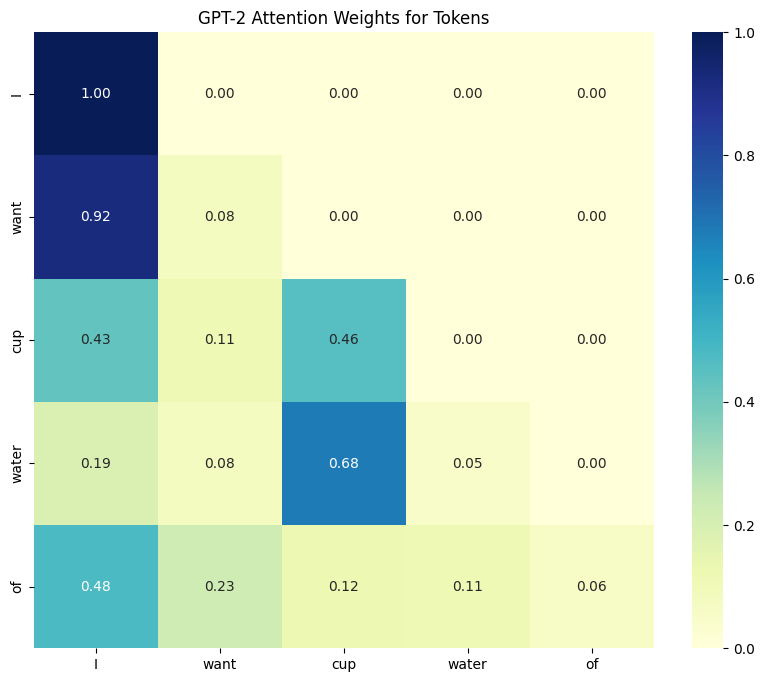

In [10]:
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import seaborn as sns

model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

def generate_attention_plot(tokens):
    input_ids = tokenizer.encode(" ".join(tokens), return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        attentions = outputs.attentions
    attention_weights = attentions[0][0, 0].cpu().numpy()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(attention_weights, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens)
    plt.title('GPT-2 Attention Weights for Tokens')
    plt.show()

generate_attention_plot(tokens[1])

In [15]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

def visualize_parse_tree(sentence):
    doc = nlp(sentence)
    displacy.render(doc, style="dep", jupyter=True)

In [17]:
visualize_parse_tree(generated_sentence)

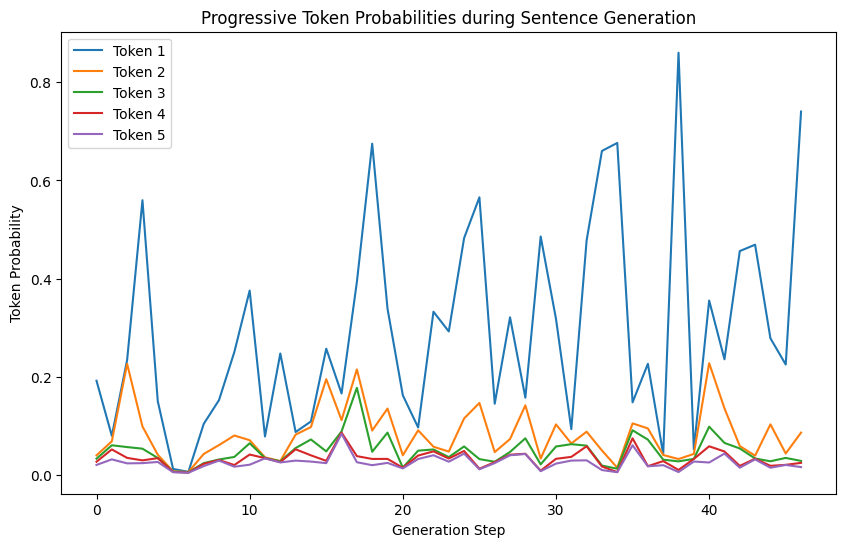

Generated Sentence: ie  points  out  that  the  " s ugar "  in  the  sugar  is  not  the  sugar  itself ,  but  the  sugar  that  is  added  to  the  sugar .  The  sugar  is  added  to  the  sugar  by  the  process  of  fermentation .  The  sugar  is  then  added  to


In [18]:
import matplotlib.pyplot as plt
def visualize_sentence_progression(tokens):
    input_ids = tokenizer.encode(" ".join(tokens), return_tensors="pt")
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    all_probabilities = []
    generated_sentence = []
    for i in range(len(tokens), 50):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            next_token_probs = torch.nn.functional.softmax(logits[0, -1], dim=-1)
        top_5_probs = torch.topk(next_token_probs, 5)
        all_probabilities.append(top_5_probs.values.cpu().numpy())
        next_token_id = top_5_probs.indices[0].item()
        next_token = tokenizer.decode(next_token_id)
        input_ids = torch.cat((input_ids, torch.tensor([[next_token_id]])), dim=1)
        generated_sentence.append(next_token)
    all_probabilities = np.array(all_probabilities)
    plt.figure(figsize=(10, 6))
    plt.plot(all_probabilities)
    plt.title('Progressive Token Probabilities during Sentence Generation')
    plt.xlabel('Generation Step')
    plt.ylabel('Token Probability')
    plt.legend([f'Token {i+1}' for i in range(5)])
    plt.show()
    print(f"Generated Sentence: {' '.join(generated_sentence)}")

visualize_sentence_progression(tokens)

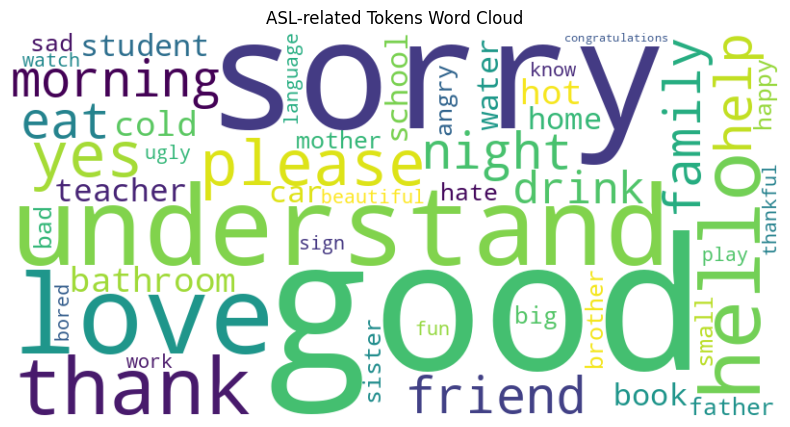

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(asl_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("ASL-related Tokens Word Cloud")
plt.show()

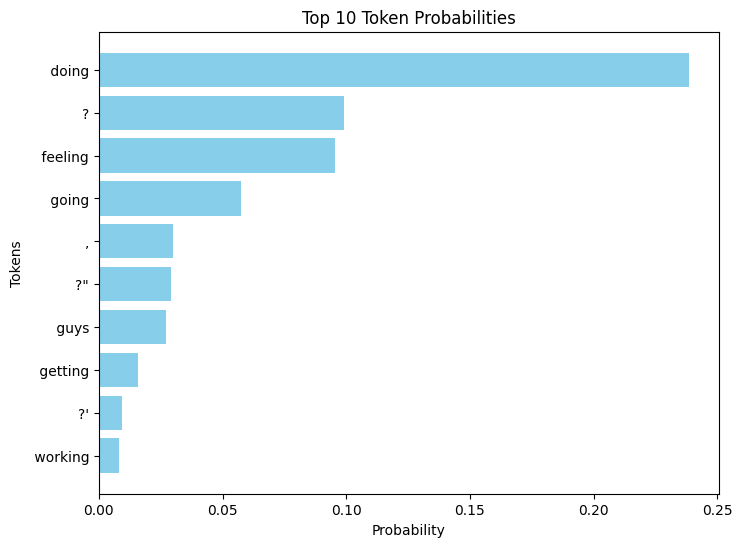

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
def plot_token_probabilities(tokens):
    input_ids = tokenizer.encode(" ".join(tokens), return_tensors="pt")
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits[0, -1], dim=-1).cpu().numpy()
    top_k = 10
    top_k_indices = np.argsort(probabilities)[-top_k:]
    top_k_probs = probabilities[top_k_indices]
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices]
    plt.figure(figsize=(8, 6))
    plt.barh(top_k_tokens, top_k_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.ylabel('Tokens')
    plt.title("Top 10 Token Probabilities")
    plt.show()

plot_token_probabilities(tokens[5])